In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [5]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

In [6]:
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
path="/content/drive/My Drive/FYP/LSTM/"

In [8]:
BATCH_SIZE= 128

DROPING DUPLICATES

In [9]:
train = pd.read_csv(path+"train.csv")
print("before droping duplicates:",len(train))
train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
print("after droping duplicates:",len(train))
test = pd.read_csv(path+"test.csv")

before droping duplicates: 1549
after droping duplicates: 1535


In [10]:
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [11]:
sub = pd.read_csv(path+"sample_submission.csv")
sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100
...,...,...,...
725,ID00419637202311204720264_133,2000,100
726,ID00421637202311550012437_133,2000,100
727,ID00422637202311677017371_133,2000,100
728,ID00423637202312137826377_133,2000,100


Splitting "Patient_Week" column as "Patient" and "Week"

In [12]:
sub = pd.read_csv(path+"sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub

,Patient,Weeks,Confidence,Patient_Week
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12
1,ID00421637202311550012437,-12,100,ID00421637202311550012437_-12
2,ID00422637202311677017371,-12,100,ID00422637202311677017371_-12
3,ID00423637202312137826377,-12,100,ID00423637202312137826377_-12
4,ID00426637202313170790466,-12,100,ID00426637202313170790466_-12
...,...,...,...,...
725,ID00419637202311204720264,133,100,ID00419637202311204720264_133
726,ID00421637202311550012437,133,100,ID00421637202311550012437_133
727,ID00422637202311677017371,133,100,ID00422637202311677017371_133
728,ID00423637202312137826377,133,100,ID00423637202312137826377_133


In [13]:
sub['Weeks']

0      -12
1      -12
2      -12
3      -12
4      -12
      ... 
725    133
726    133
727    133
728    133
729    133
Name: Weeks, Length: 730, dtype: int64

In [14]:
sub = sub.merge(test.drop('Weeks', axis=1), on="Patient")
sub

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186855,73,Male,Ex-smoker
...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,100,ID00426637202313170790466_129,2925,71.824968,73,Male,Never smoked
726,ID00426637202313170790466,130,100,ID00426637202313170790466_130,2925,71.824968,73,Male,Never smoked
727,ID00426637202313170790466,131,100,ID00426637202313170790466_131,2925,71.824968,73,Male,Never smoked
728,ID00426637202313170790466,132,100,ID00426637202313170790466_132,2925,71.824968,73,Male,Never smoked


In [15]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [16]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [17]:
train['WHERE'] = 'train'
test['WHERE'] = 'val'
sub['WHERE'] = 'test'

In [18]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train
...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,train
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,train
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,train
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,train


In [19]:
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,val
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,val
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,val
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,val
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,val


In [20]:
sub

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus,WHERE
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker,test
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker,test
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker,test
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker,test
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186855,73,Male,Ex-smoker,test
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,100,ID00426637202313170790466_129,2925,71.824968,73,Male,Never smoked,test
726,ID00426637202313170790466,130,100,ID00426637202313170790466_130,2925,71.824968,73,Male,Never smoked,test
727,ID00426637202313170790466,131,100,ID00426637202313170790466_131,2925,71.824968,73,Male,Never smoked,test
728,ID00426637202313170790466,132,100,ID00426637202313170790466_132,2925,71.824968,73,Male,Never smoked,test


In [21]:
data = train.append([test, sub])
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_129
726,ID00426637202313170790466,130,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_130
727,ID00426637202313170790466,131,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_131
728,ID00426637202313170790466,132,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_132


In [22]:
print('Training Data:',train.info(), end = "\n\n\n")

print('Testing Data:',test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1535 entries, 0 to 1548
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1535 non-null   object 
 1   Weeks          1535 non-null   int64  
 2   FVC            1535 non-null   int64  
 3   Percent        1535 non-null   float64
 4   Age            1535 non-null   int64  
 5   Sex            1535 non-null   object 
 6   SmokingStatus  1535 non-null   object 
 7   WHERE          1535 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 107.9+ KB
Training Data: None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4  

In [23]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0


In [24]:
base = data.loc[data.Weeks == data.min_week]
base

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,train,NaN,NaN,8.0
18,ID00010637202177584971671,0,3523,94.724672,60,Male,Ex-smoker,train,NaN,NaN,0.0
27,ID00011637202177653955184,6,3326,85.987590,72,Male,Ex-smoker,train,NaN,NaN,6.0
36,ID00012637202177665765362,33,3418,93.726006,65,Male,Never smoked,train,NaN,NaN,33.0
...,...,...,...,...,...,...,...,...,...,...,...
18,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_6,6.0
173,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_15,15.0
310,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,test,100.0,ID00422637202311677017371_6,6.0
467,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,test,100.0,ID00423637202312137826377_17,17.0


In [25]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [26]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [27]:
COLS = ['Sex','SmokingStatus']
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [28]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [29]:
train = data.loc[data.WHERE=='train']
test = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [30]:
train.shape, test.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

In [31]:
L.Bidirectional

keras.layers.rnn.bidirectional.Bidirectional

In [42]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    # print(y_true[:, 0])
    # print(fvc_pred)
    y_true=float(y_true[:, 0])
    delta = tf.abs(y_true - fvc_pred)
    # print("hi")
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    y_true=float(y_true)
    e = y_true - y_pred
    # print("hi")
   
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        # print(y_pred)
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================
def make_model():
    z = L.Input((9,), name="Patient")
    y = L.Bidirectional(L.LSTM(25, return_sequences=True))(tf.expand_dims(z, axis=-1))
    y = L.Bidirectional(L.LSTM(25, return_sequences=True))(y)
    y = L.Reshape([450])(y)
    x = L.Dense(100, activation="relu", name="d1")(y)
    x = L.Dense(100, activation="relu", name="d2")(x)
    x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
   
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
   
    model = M.Model(z, preds, name="CNN")
    
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer="adam", metrics=[score])
    
    return model

In [43]:
net = make_model()
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Patient (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 tf.expand_dims_4 (TFOpLambda)  (None, 9, 1)         0           ['Patient[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 9, 50)       5400        ['tf.expand_dims_4[0][0]']       
 )                                                                                                
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 9, 50)       15200       ['bidirectional_6[0][0]']      

In [44]:
y = train['FVC'].values
z = train[FE].values
ze = sub[FE].values
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [45]:
NFOLD = 15
kf = KFold(n_splits=NFOLD)

In [48]:
%%time
cnt = 0
i = 0
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model()
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=800, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    val_score = net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE)
    print("val", val_score)
    print("predict val...")
    print("predict test...")
    if val_score[1] < 6.8:
        pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
        pe = pe*i
        pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0)
        i+=1
        pe = pe/i

FOLD 1
train [39.88459396362305, 6.535738468170166]
val [50.76970672607422, 6.720829486846924]
predict val...
predict test...
FOLD 2
train [40.86970138549805, 6.5458455085754395]
val [50.159889221191406, 6.684421539306641]
predict val...
predict test...
FOLD 3
train [39.432525634765625, 6.535938739776611]
val [47.98407745361328, 6.677680969238281]
predict val...
predict test...
FOLD 4
train [38.68518829345703, 6.490543365478516]
val [53.63880157470703, 6.735544204711914]
predict val...
predict test...
FOLD 5
train [40.54317855834961, 6.523740291595459]
val [52.269317626953125, 6.735332489013672]
predict val...
predict test...
FOLD 6
train [40.03107833862305, 6.568054676055908]
val [41.056121826171875, 6.615267276763916]
predict val...
predict test...
FOLD 7
train [38.94344711303711, 6.530139446258545]
val [46.470741271972656, 6.672830581665039]
predict val...
predict test...
FOLD 8
train [39.99192810058594, 6.5514750480651855]
val [87.5058364868164, 7.183714389801025]
predict val...
pr

In [49]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

491.6431016356627 208.65899849062245


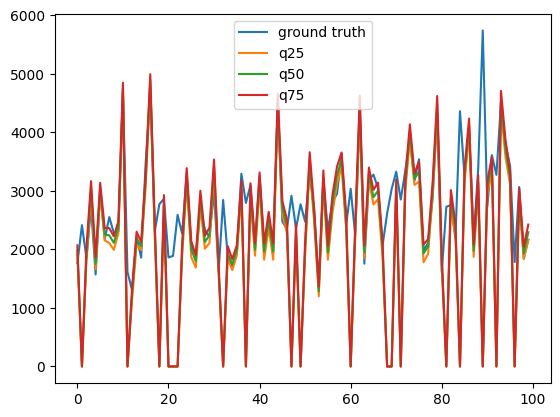

In [50]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [51]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

0.0 208.65899849062245 374.183837890625 1.0


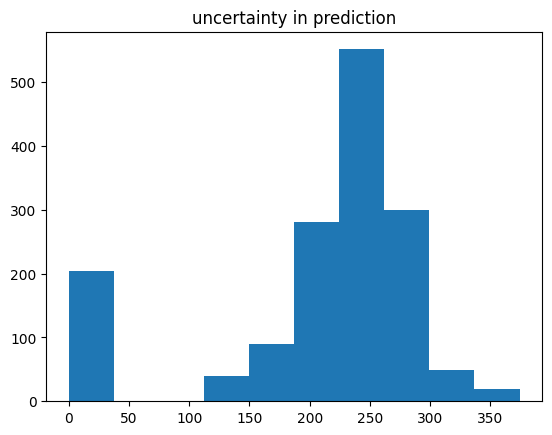

In [52]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()


In [53]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [54]:
sub['FVC1'] = 0.996  * pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]

In [55]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [56]:
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2866.166649,239.778771
1541,ID00419637202311204720264_-11,3020,100.0,2863.069226,240.473764
1542,ID00419637202311204720264_-10,3020,100.0,2859.890267,241.169772
1543,ID00419637202311204720264_-9,3020,100.0,2856.660936,241.867169
1544,ID00419637202311204720264_-8,3020,100.0,2853.416005,242.567326
1545,ID00419637202311204720264_-7,3020,100.0,2850.115820,243.269400
1546,ID00419637202311204720264_-6,3020,100.0,2846.759389,243.976638
1547,ID00419637202311204720264_-5,3020,100.0,2843.443622,244.690448
1548,ID00419637202311204720264_-4,3020,100.0,2840.168595,245.411640
1549,ID00419637202311204720264_-3,3020,100.0,2836.929033,246.139817


In [57]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [58]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2866.166649,239.778771,2866.166649,239.778771
1541,ID00419637202311204720264_-11,2863.069226,240.473764,2863.069226,240.473764
1542,ID00419637202311204720264_-10,2859.890267,241.169772,2859.890267,241.169772
1543,ID00419637202311204720264_-9,2856.660936,241.867169,2856.660936,241.867169
1544,ID00419637202311204720264_-8,2853.416005,242.567326,2853.416005,242.567326


In [59]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2641.140091,322.847909,2015.121638,2644.774641,2670.523447,2822.458311,3201.369301
Confidence,730.0,272.876501,21.641301,214.909105,256.828071,279.645414,291.614746,298.969032
FVC1,730.0,2641.140091,322.847909,2015.121638,2644.774641,2670.523447,2822.458311,3201.369301
Confidence1,730.0,272.876501,21.641301,214.909105,256.828071,279.645414,291.614746,298.969032


In [60]:
otest = pd.read_csv(path+'test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [61]:
subm[["Patient_Week","FVC","Confidence"]].to_csv(path+"submission_MQR_BiDirectionalLSTM.csv", index=False)